# Introduction - Violent crime analysis during lockdown Britain

There had been reports of an increase in the degree of domestic violence during the lockdown, therefore the situation was heightened. The question is whether the rise in domestic violence coincided with a spike in general violent crime in the United Kingdom during the lockdown. This project will conduct an analysis to determine whether there is an overall increase in violent crime during the lockdown. 

In order to successfully carry out this analysis, the crime categories will be analyzed, and filtered to identify the appropriate crime data for analysis and prediction.

**Dataset**: The dataset used for this analysis is the "UK Police Official street level crime data 2021". 

# Neccessary Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
#from pyspark.pandas import read_csv
from pyspark.sql.functions import count, avg, sum
from pyspark.sql.functions import col, desc
from pyspark import SparkFiles

import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime


import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns




# Starting up Spark Session

Before implementing Spark and it's modules, a Spark connection needs to be established. To establish this connection, we need the Spark Context object. Futhermore, with spark context, RDDs can be created and the access to SparkSQL is also enabled with just the SQLContext interaction.

In [2]:
spark = SparkSession\
.builder\
.appName("Violent Crime Investigation in UK")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[*] appName=Violent Crime Investigation in UK>

In [4]:
pwd

'/home/notebookuser'

In [6]:
#RDD = sc.textFile("https://unnkf7032.blob.core.windows.net/kf7032assign-data/all_crimes21_hdr.txt.gz")

In [7]:
#RDD = RDD.repartition(numPartitions=2000)
#/Users/solo/Documents/all_crimes21_hdr.txt.gz
#https://solomonkf7032storage.blob.core.windows.net/solomon-container/all_crimes21_hdr.txt.gz

In [8]:
#Getting the dataset from my blob storage
location = "https://solomonkf7032storage.blob.core.windows.net/solomon-container/all_crimes21_hdr.txt.gz"

In [9]:
#Adding the dataset to spark
spark.sparkContext.addFile(location)

In [10]:
#Ensuring that the blob storage path is right
location

'https://solomonkf7032storage.blob.core.windows.net/solomon-container/all_crimes21_hdr.txt.gz'

In [11]:
#Creating a more structured dataframe in the dataset using .csv 
df = spark.read.csv(SparkFiles.get("all_crimes21_hdr.txt.gz"), header = True, inferSchema = True)

In [12]:
#A test to verify if the dataset was loaded properly by using the .show() with just one row  
df.show(1)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|          LSOA name| Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662|Aylesbury Vale 015C|Other crime|                 null|   null|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
only showing top 1 row



# Crime Categories

This is a list of all the crime categories used by the police

In [13]:
#Using try and catch to catch any errors that might occur when running the below code
#The below code is an SQL query that selects all from the dataframe, grouping-by the "Crime type" category as this this is a column for all crime types and also uses the aggregate to count the total crimes. Then ordering by Crime type
try:
    
    count_df = (df
     .select("*")
     .groupBy("Crime type")
     .agg(count("Crime type").alias("Total"))
     .orderBy("Crime type")) 
    

except Exception as x:
    print(str(x))



In [14]:
#The codes below prints out message to tell what the code follwoing it does when executed.
print("Crime categories in Police data:")
count_df.select("Crime type").show()#selects the "Crime type" category and displays all the categories

Crime categories in Police data:
+--------------------+
|          Crime type|
+--------------------+
|Anti-social behav...|
|       Bicycle theft|
|            Burglary|
|Criminal damage a...|
|               Drugs|
|         Other crime|
|         Other theft|
|Possession of wea...|
|Public disorder a...|
|        Public order|
|             Robbery|
|         Shoplifting|
|Theft from the pe...|
|       Vehicle crime|
|Violence and sexu...|
|       Violent crime|
+--------------------+



In [15]:
print("Crime categories in the Police data in clean format:")

count_df.select("Crime type").toPandas()#used in this context to display the "Crime type" category better

Crime categories in the Police data in clean format:


,Crime type
0,Anti-social behaviour
1,Bicycle theft
2,Burglary
3,Criminal damage and arson
4,Drugs
5,Other crime
6,Other theft
7,Possession of weapons
8,Public disorder and weapons
9,Public order


# Crime Categories Consistency

In [16]:
try:
    
    count_df = (df
     .select("*")
     .groupBy("Month","Crime type")
     .agg(count("Crime type").alias("Total"))
     .orderBy("Month")) 
    

except Exception as x:
    print(str(x))

    
print("Crime categories consistency from the year 2010 - 2021:")
count_df.show(55000)



Crime categories consistency from the year 2010 - 2021:
+-------+--------------------+------+
|  Month|          Crime type| Total|
+-------+--------------------+------+
|2010-12|            Burglary| 37893|
|2010-12|             Robbery|  5731|
|2010-12|Anti-social behav...|201016|
|2010-12|         Other crime|142705|
|2010-12|       Vehicle crime| 29416|
|2010-12|       Violent crime| 57580|
|2011-01|            Burglary| 44388|
|2011-01|         Other crime|167072|
|2011-01|             Robbery|  6667|
|2011-01|       Violent crime| 59823|
|2011-01|Anti-social behav...|201792|
|2011-01|       Vehicle crime| 34899|
|2011-02|       Violent crime| 56691|
|2011-02|            Burglary| 41821|
|2011-02|             Robbery|  6480|
|2011-02|Anti-social behav...|206801|
|2011-02|       Vehicle crime| 33591|
|2011-02|         Other crime|168945|
|2011-03|         Other crime|189038|
|2011-03|       Violent crime| 62326|
|2011-03|       Vehicle crime| 35174|
|2011-03|Anti-social behav...|24

In [17]:
count_df

DataFrame[Month: string, Crime type: string, Total: bigint]

In [18]:
df.select()

DataFrame[]

# Are levels of violent crime increasing, decreasing or constant?

From the previous section, it is seen that the crime category "violent crime" changed from "violent crime" to "violence and sexual offence" in April 2013. This section analyzes both the violent crime from 2010 - 2013, and violence and sexual offence from 2013 - 2021. 

**Analysis of violent crime from 2010 - 2013**

In [19]:
try:
    
    count_df = (df
     .select("*")
     .where(df["Crime type"] == "Violent crime") 
     .groupBy("Month","Crime type")
     .agg(count("Crime type").alias("Total"))
     .orderBy("Month")) 
    

except Exception as x:
    print(str(x))


print("Violent crime data from year 2010 to 2013")
count_df.show(55000)

Violent crime data from year 2010 to 2013
+-------+-------------+-----+
|  Month|   Crime type|Total|
+-------+-------------+-----+
|2010-12|Violent crime|57580|
|2011-01|Violent crime|59823|
|2011-02|Violent crime|56691|
|2011-03|Violent crime|62326|
|2011-04|Violent crime|64299|
|2011-05|Violent crime|63633|
|2011-06|Violent crime|62475|
|2011-07|Violent crime|66572|
|2011-08|Violent crime|63284|
|2011-09|Violent crime|57150|
|2011-10|Violent crime|60076|
|2011-11|Violent crime|56895|
|2011-12|Violent crime|56163|
|2012-01|Violent crime|56324|
|2012-02|Violent crime|50598|
|2012-03|Violent crime|58606|
|2012-04|Violent crime|53415|
|2012-05|Violent crime|59541|
|2012-06|Violent crime|56816|
|2012-07|Violent crime|60199|
|2012-08|Violent crime|59217|
|2012-09|Violent crime|55144|
|2012-10|Violent crime|56876|
|2012-11|Violent crime|54424|
|2012-12|Violent crime|55572|
|2013-01|Violent crime|53872|
|2013-02|Violent crime|47842|
|2013-03|Violent crime|54439|
|2013-04|Violent crime|53367

**Visualization of violent crime from 2010 to 2013 using matplotlib**

In [21]:
#Before any visualization is done, the dataframe has to be converted to Pandas()
count_df = count_df.toPandas()

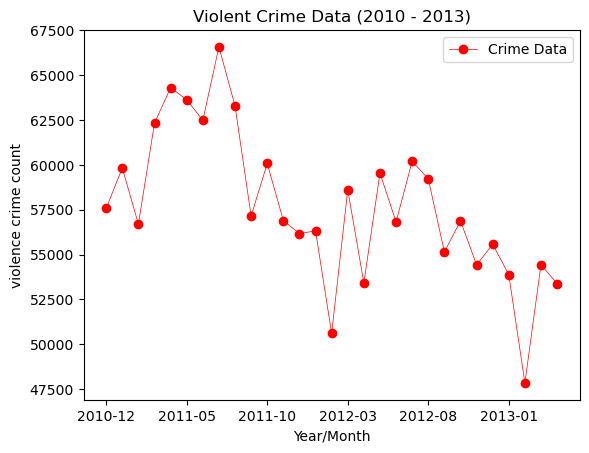

In [22]:
plt.figsize=(20, 6)
count_df.plot(y='Total', x='Month',marker='o', linestyle='-', color ='r', linewidth=0.5,\
subplots=False,
label='Crime Data',
title='Violent Crime Data (2010 - 2013)')
plt.ylabel('violence crime count')
plt.xlabel('Year/Month')
plt.show()

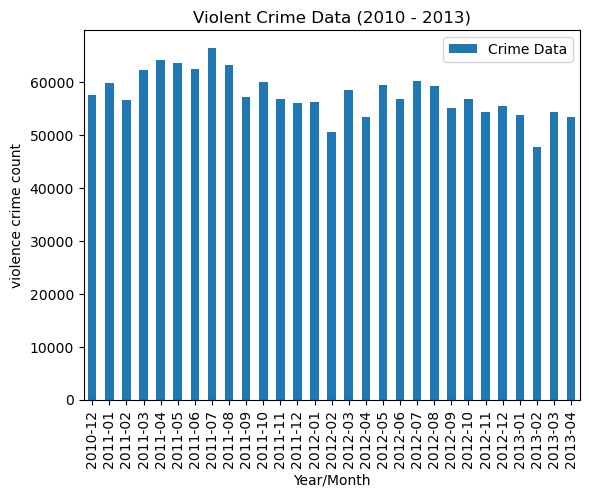

In [23]:
#A bar plot that clearly shows the month of the year between 2010 and 2013 that has a high violent crime count 
plt.figsize=(20, 6)
count_df.plot(y='Total', x='Month', kind="bar",\
subplots=False,
label='Crime Data',
title='Violent Crime Data (2010 - 2013)')
plt.ylabel('violence crime count')
plt.xlabel('Year/Month')
plt.show()

**Visualization of violent crime from 2010 to 2013 using seaborn**

In comparing both the visualization using matplotlib and seaborn for the analysis of violent crime form the year 2010 - 2013, it is clear to see that the visualization using matplotlib clearly gives better insight to the trend of violent crime between the years mentioned.

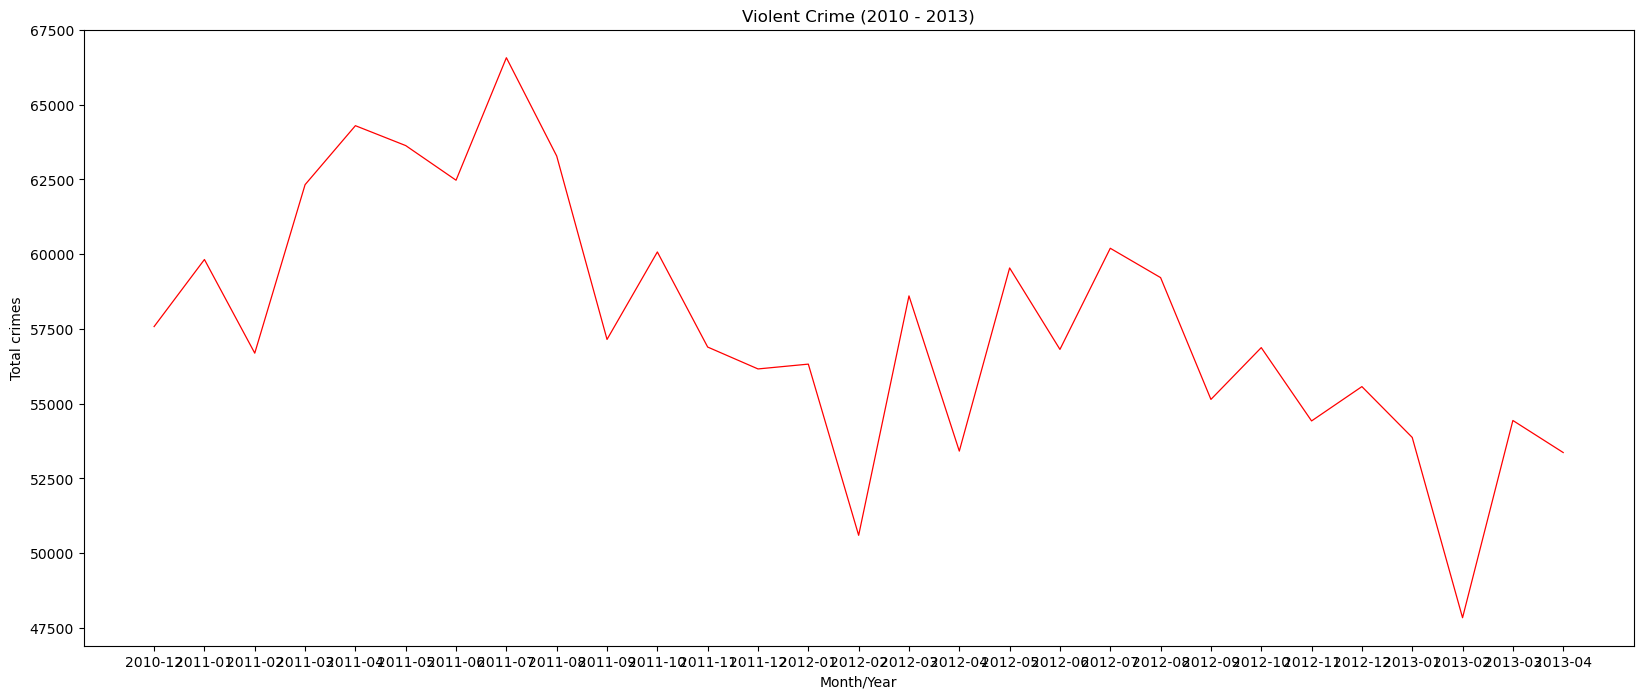

In [24]:
#Line plot using seaborn
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=count_df, x = 'Month', y = 'Total', color = 'red', linewidth=0.9)
ax.set_title("Violent Crime (2010 - 2013)")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total crimes")
plt.show()

<Figure size 2000x800 with 0 Axes>

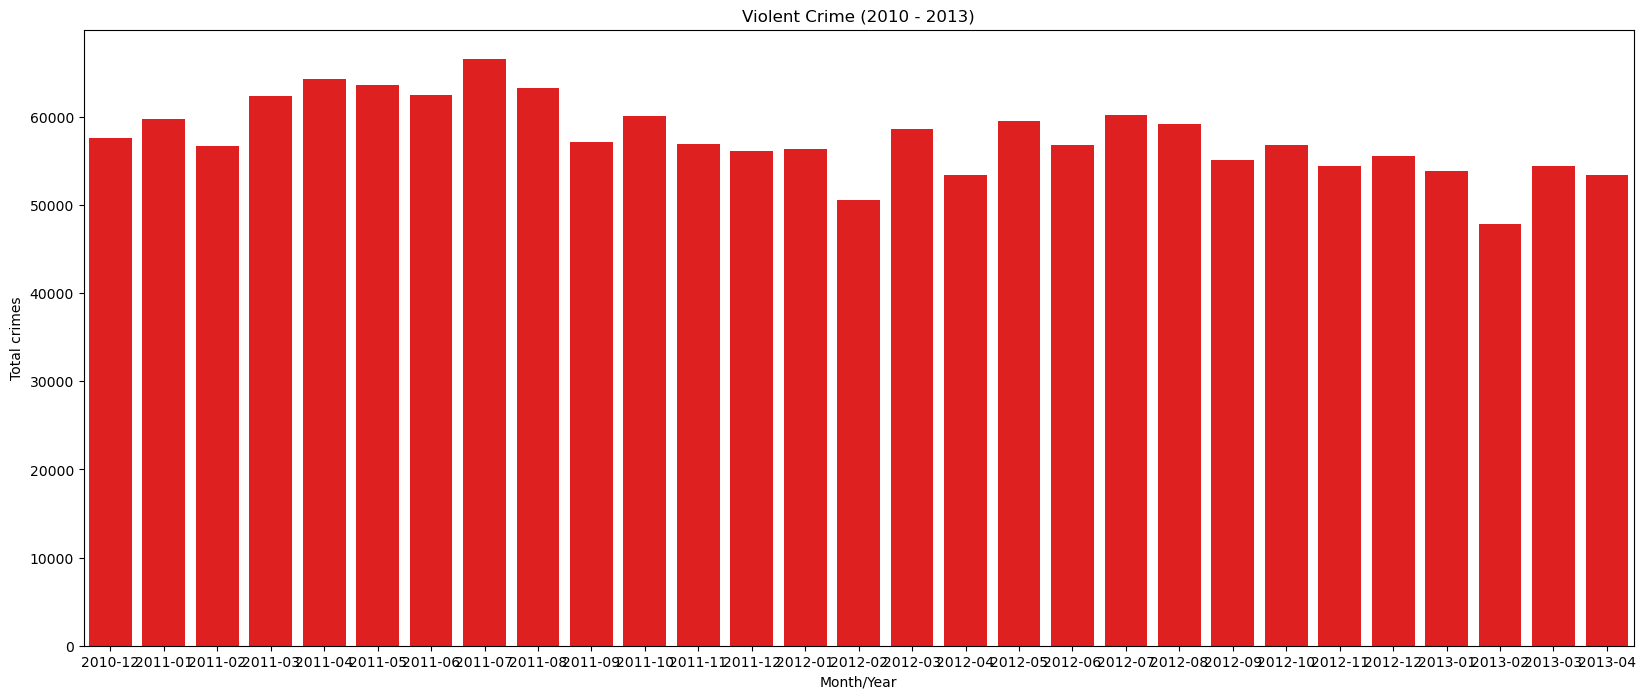

In [25]:
#Bar plot using seaborn
plt.figure(figsize=(20,8))
grid = (20,8)
fig,ax = plt.subplots(figsize = grid )
ax = sns.barplot(data=count_df, x = "Month", y = "Total", color = 'red')
ax.set_title("Violent Crime (2010 - 2013)")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total crimes")
plt.show()

**Analysis of violence and Sexual Offence from 2013 - 2021**

This analysis is the most recent and therfore better to analyse and to use when making future predictions and decisions. 

In [49]:
try:
    
    count_df2 = (df
     .select("*")
     .where(df["Crime type"] == "Violence and sexual offences")
     .groupBy("Month","Crime type")
     .agg(count("Crime type").alias("Total"))
     .orderBy("Month")) 
    

except Exception as x:
    print(str(x))

**Visualization of violence and sexual offences from 2013 to 2021**

Looking at the visuaizations below, it is evident that the violence and sexual offence crime is on the increase between the year 2013 and 2021. 

In [50]:
 violence_data = count_df2.toPandas()

**Visualization using matplotlib**

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

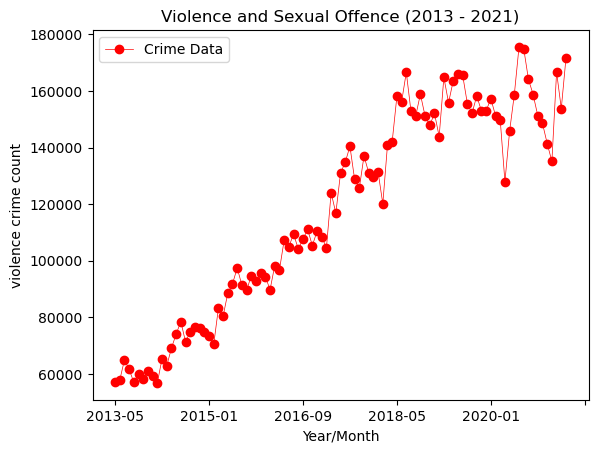

In [51]:
plt.figure(figsize=(10,7))
violence_data.plot(y='Total', x='Month',marker='o', linestyle='-', color ='r', linewidth=0.5,\
subplots=False,
label='Crime Data',
title='Violence and Sexual Offence (2013 - 2021)')
plt.ylabel('violence crime count')
plt.xlabel('Year/Month')
plt.show()

**Visualization using seaborn**

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

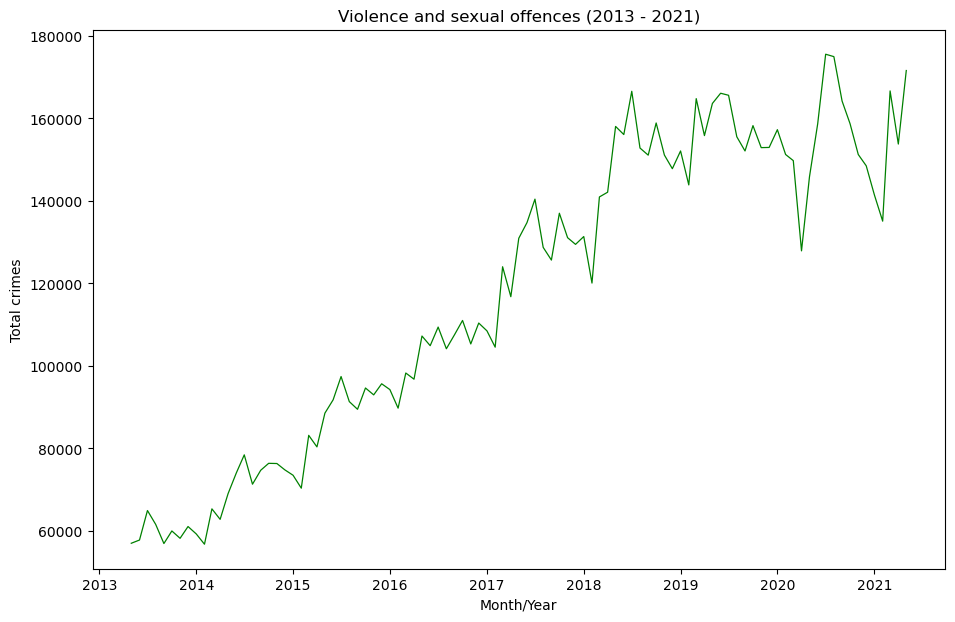

In [167]:
#Line plot using seaborn
plt.figure(figsize=(11,7))
ax = sns.lineplot(data=violence_data, x = 'Month', y = 'Total', color = 'green', linewidth=0.9)
ax.set_title("Violence and sexual offences (2013 - 2021)")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total crimes")
plt.show()

**Converting the dataframe date to datetime as this is accepted date data type for time series analysis**

Time series uses either the periods or datetime64 as the data type for its date

In [53]:
#renaming the date from "Month" to "Date" as it makes more sense
violence_data.rename(columns={'Month': 'Date'}, inplace=True)
violence_data['Date'] = violence_data['Date'].astype('datetime64[ns]')
pdata = violence_data.set_index(pd.to_datetime(violence_data['Date']))


In [54]:
pdata['Date']#just confirming the data type of the date and if it was successfully renamed

Date
2013-05-01   2013-05-01
2013-06-01   2013-06-01
2013-07-01   2013-07-01
2013-08-01   2013-08-01
2013-09-01   2013-09-01
                ...    
2021-01-01   2021-01-01
2021-02-01   2021-02-01
2021-03-01   2021-03-01
2021-04-01   2021-04-01
2021-05-01   2021-05-01
Name: Date, Length: 97, dtype: datetime64[ns]

In [56]:
#ensures that pandas datatypes can be used in matplotlib
pd.plotting.register_matplotlib_converters()

# Time series analysis and forecasting

It is important to have an overview of the time series data to have an insight of the data before forecasting. This overview is done using data decompostion. This deconstructs the data into levels, trend, seasonality and noise

# Analysis:

**Decomposition:**

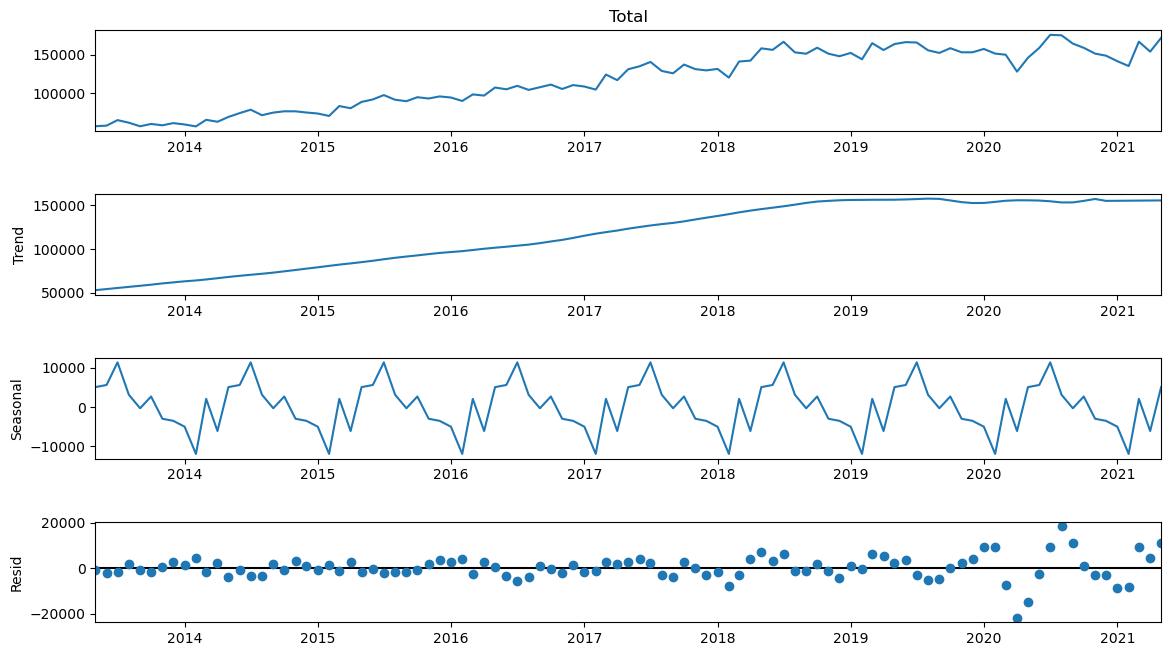

In [58]:

decomposition = sm.tsa.seasonal_decompose(pdata['Total'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(13,7)
#plt.plot(row.index, row.values)
plt.show()


**The Observed and Trend can be displayed sepretely to see clearly.**

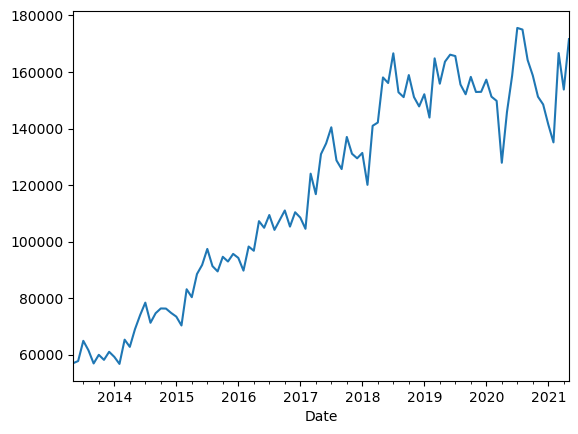

In [59]:
#Observed data
level = decomposition.observed
level.plot()
plt.show()

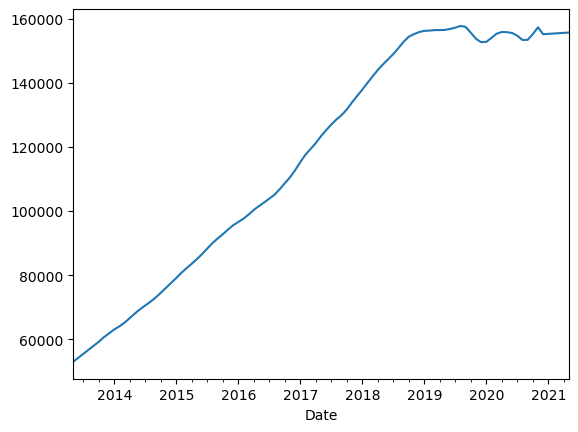

In [60]:
#Trend data
trend = decomposition.trend
trend.plot()
plt.show()

From the decompositon visualization above, it is clear that the time series data has trend and seasonality. This means the time series data is not stationary. However, there is even a more suitable way to test for the staionarity of time series data.

**Test for stationarity**

In [62]:
#function to test for stationarity of data
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

In [63]:
#getting the date data to be used for analysis and prediction and dropping the values that are null
y = pdata.set_index(pd.to_datetime(pdata['Date'])).dropna().Total

**Visualizing the stationarity of the data using the "test_stationarity function".**

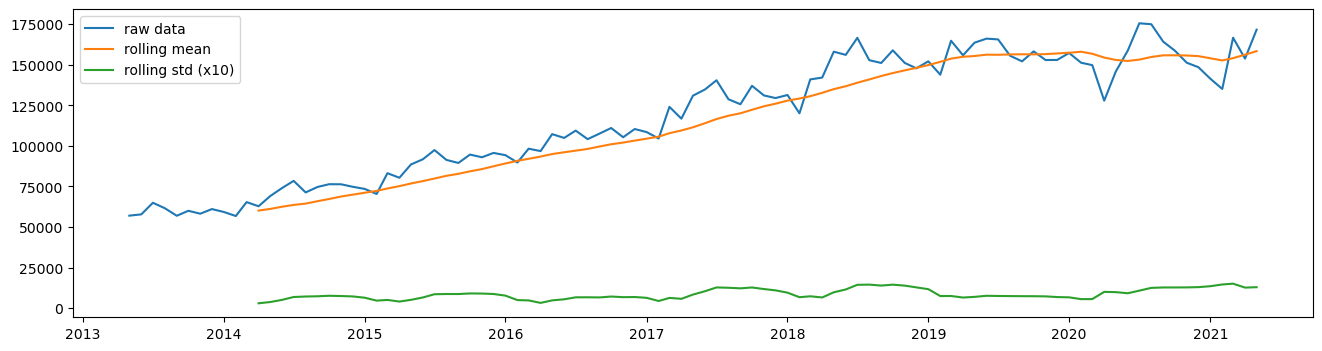

In [64]:
#visualize data using the above defined function
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')#above defined function to test stationarity
plt.show()#visualizing data stationarity with matplotlib

Now that it is clear that the time series data is not stationary, methods need to be implemented to make it stationary and confirm the stationarity.

In [67]:
from statsmodels.tsa.stattools import adfuller
# the augmented dickey fuller test is used here to validate the time series stationarity
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

One way of making a time series data stationary is using Differencing or Detrending. Differencing/Detrending is a way of removing trends and seasonality in a time series data. 

For some reason, the time series data was unable to be made stationary with Differencing, Detrending, and even both combined.

In order for it to be stationary, the Differencing was implemented within another differencing and so on. This method was able to successfully make the time series data stationary.

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.433
P-value = 0.566
Critical values :
	1%: -3.524624466842421 - The data is not stationary with 99% confidence
	5%: -2.9026070739026064 - The data is not stationary with 95% confidence
	10%: -2.5886785262345677 - The data is not stationary with 90% confidence


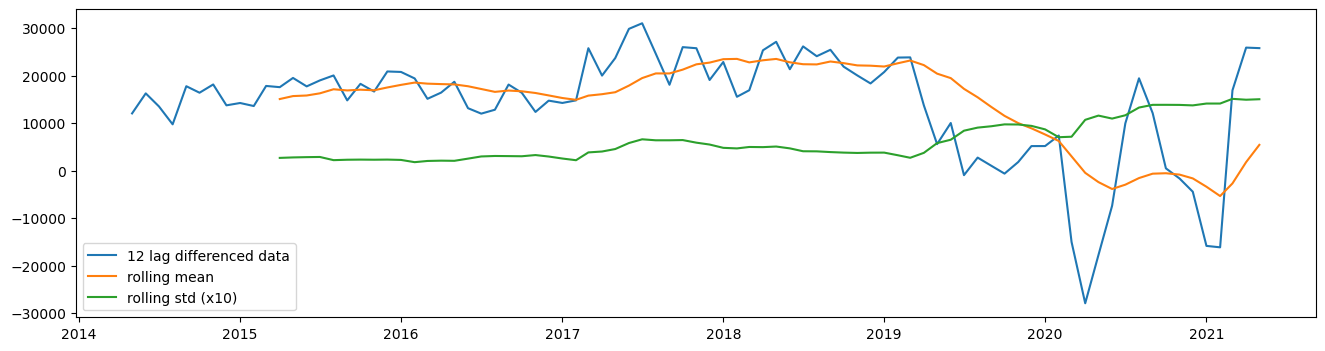

In [68]:
#Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')
plt.show()

 > Is the 12 lag differenced data stationary ?
Test statistic = -2.101
P-value = 0.244
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


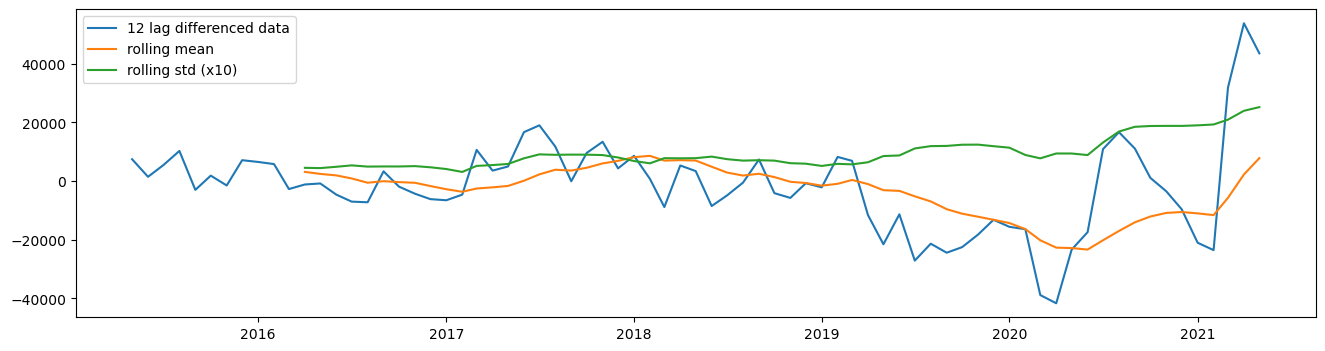

In [69]:
#Differencing
y_12lag1 =  y_12lag - y_12lag.shift(12)

test_stationarity(y_12lag1,'12 lag differenced data')
ADF_test(y_12lag1,'12 lag differenced data')
plt.show()

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.420
P-value = 0.010
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is  stationary with 95% confidence
	10%: -2.5993358475635153 - The data is  stationary with 90% confidence


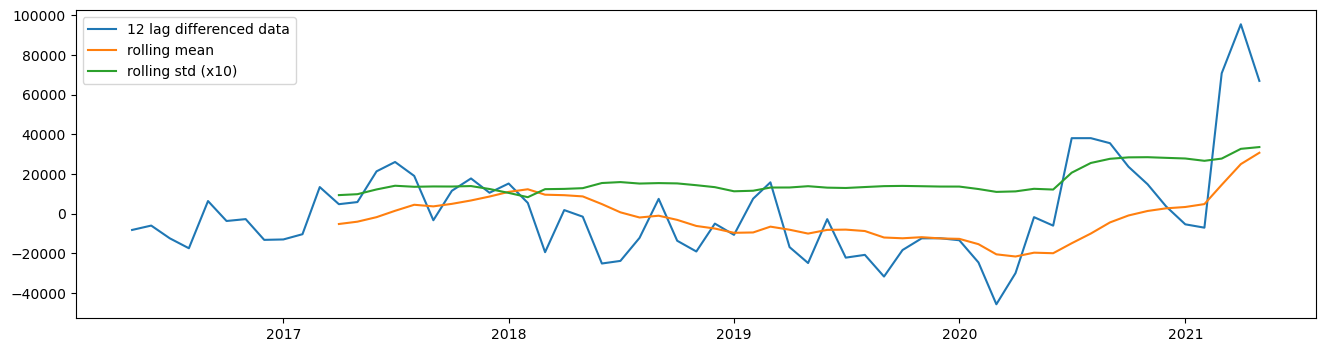

In [70]:
#Differencing
y_12lag2 =  y_12lag1 - y_12lag1.shift(12)

test_stationarity(y_12lag2,'12 lag differenced data')
ADF_test(y_12lag2,'12 lag differenced data')
plt.show()

 > Is the 12 lag differenced data stationary ?
Test statistic = -2.069
P-value = 0.257
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is not stationary with 95% confidence
	10%: -2.6104002410518627 - The data is not stationary with 90% confidence


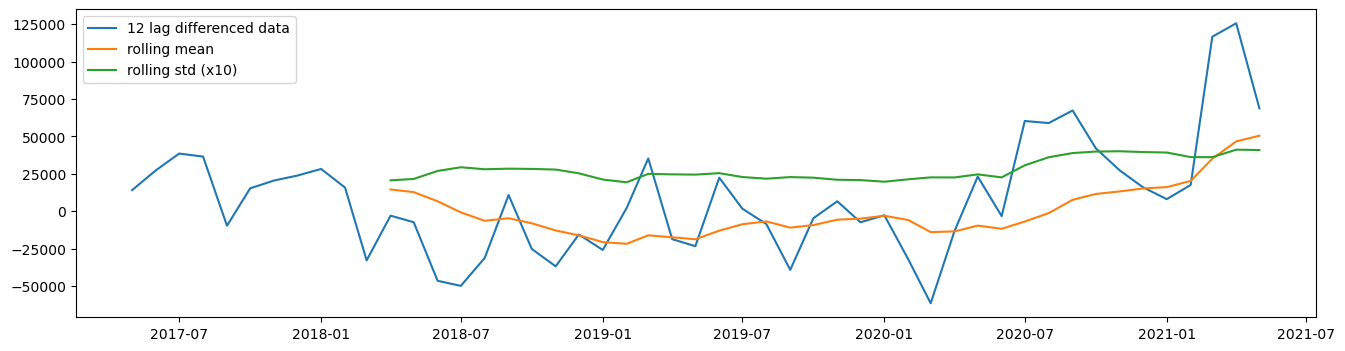

In [71]:
#Differencing
y_12lag3 =  y_12lag2 - y_12lag2.shift(12)

test_stationarity(y_12lag3,'12 lag differenced data')
ADF_test(y_12lag3,'12 lag differenced data')
plt.show()

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.115
P-value = 0.025
Critical values :
	1%: -3.626651907578875 - The data is not stationary with 99% confidence
	5%: -2.9459512825788754 - The data is  stationary with 95% confidence
	10%: -2.6116707716049383 - The data is  stationary with 90% confidence


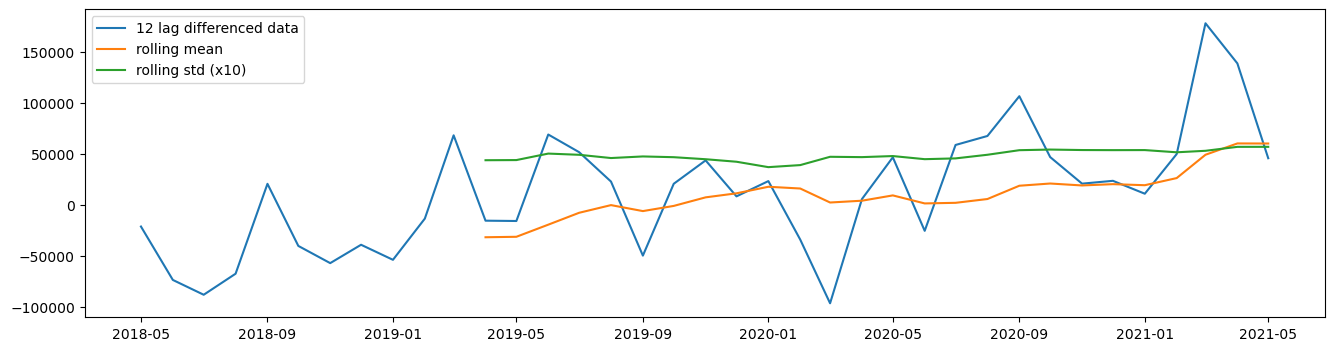

In [72]:
#Differencing
y_12lag4 =  y_12lag3 - y_12lag3.shift(12)

test_stationarity(y_12lag4,'12 lag differenced data')
ADF_test(y_12lag4,'12 lag differenced data')
plt.show()

 > Is the 12 lag differenced data stationary ?
Test statistic = -4.054
P-value = 0.001
Critical values :
	1%: -3.7529275211638033 - The data is  stationary with 99% confidence
	5%: -2.998499866852963 - The data is  stationary with 95% confidence
	10%: -2.6389669754253307 - The data is  stationary with 90% confidence


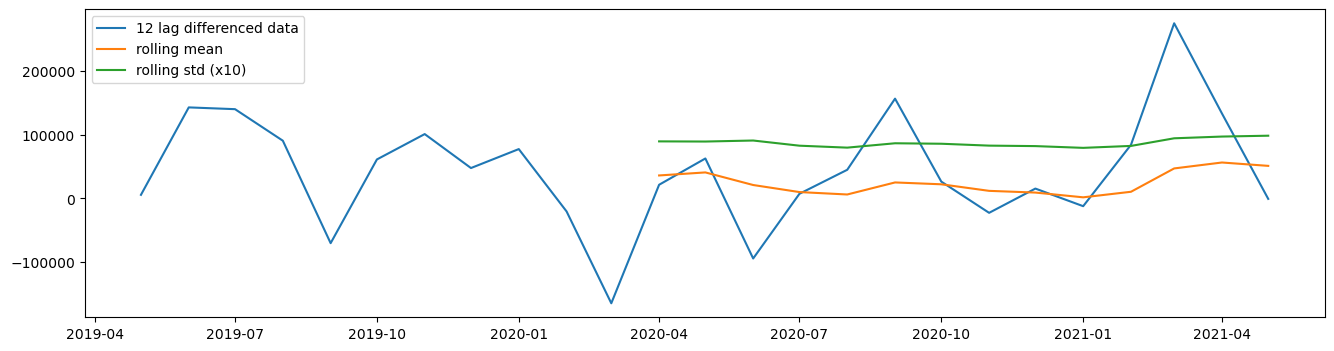

In [73]:
#Differencing
y_12lag5 =  y_12lag4 - y_12lag4.shift(12)

test_stationarity(y_12lag5,'12 lag differenced data')
ADF_test(y_12lag5,'12 lag differenced data')
plt.show()

In [211]:
# Detrending
#y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

#test_stationarity(y_detrend,'de-trended data')
#ADF_test(y_detrend,'de-trended data')
#plt.show()

In [212]:
#Detrending + Differencing

#y_12lag_detrend =  y_detrend - y_detrend.shift(12)
#test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
#ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

#plt.show()


# Prediction:

In [74]:
y_to_train = y[:'2019-12-01'] # dataset to train
y_to_test = y['2020-01-01':] # last X months for test  
y_to_val = y_to_test


Since the data is a seasonal data, the model to be used for training will be the extenstion of the **ARIMA** model - **SARIMAX** as this handles data with seasonal component. This is used for the purposes of training and predictions. The ARIMA model is basically a combination of the AR (Auto Regressive) and the MA (Moving Average) model, which combines to form the Auto Regressive Integrated Moving Average (ARIMA) model.

In [76]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
# implementing seasonal arima model. p is number of autoregressive; d is the degree of diferencing; q is the number of movements
p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [77]:
metric_aic_dict = dict()#this is added in order to go through the AIC in ascending order.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'\
.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param, param_seasonal): results.aic})#implemented to get the AIC in ascending order
        except Exception as ex:
            print(ex)
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2093.7706805210405
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2074.069628217937
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1531.6278068921522
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1511.5745560627104
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1921.196184907741
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1800.4443487219032
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1486.6621924361039
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1435.2339364659
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2043.13084234109
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2036.7619764990368
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1490.669670700571
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1487.103313360989
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2032.967569890127
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2034.673408407506
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1483.6783304343
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1479.1360893578017
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1631.1129486820312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1619.7260673517885
ARIMA(

In [78]:
#The code below finds out the lowest AIC as this is the best SARIMAX model
#It sorts the AIC in ascending order, making the first to be the lowest and best  
{k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{((0, 1, 1), (0, 1, 1, 12)): 1307.5724706929755,
 ((1, 1, 0), (0, 1, 1, 12)): 1308.330653673628,
 ((0, 1, 1), (1, 1, 1, 12)): 1308.6974364655136,
 ((1, 1, 1), (0, 1, 1, 12)): 1309.4810638660144,
 ((1, 1, 0), (1, 1, 1, 12)): 1309.5281626040091,
 ((0, 1, 0), (0, 1, 1, 12)): 1309.6413749431904,
 ((0, 1, 1), (1, 1, 0, 12)): 1310.2712222525302,
 ((1, 1, 1), (1, 1, 1, 12)): 1310.5899315967417,
 ((1, 1, 0), (1, 1, 0, 12)): 1310.7857279603588,
 ((0, 1, 0), (1, 1, 1, 12)): 1310.8859741215717,
 ((1, 1, 1), (1, 1, 0, 12)): 1312.2273824425627,
 ((0, 1, 0), (1, 1, 0, 12)): 1312.743447990942,
 ((0, 1, 1), (0, 1, 0, 12)): 1315.2770770584686,
 ((1, 1, 0), (0, 1, 0, 12)): 1315.394862379281,
 ((0, 1, 0), (0, 1, 0, 12)): 1317.193927395171,
 ((1, 1, 1), (0, 1, 0, 12)): 1317.2851337275104,
 ((1, 0, 1), (1, 1, 1, 12)): 1381.7718612856918,
 ((1, 0, 1), (1, 1, 0, 12)): 1389.5407250957649,
 ((1, 0, 0), (1, 1, 0, 12)): 1392.2206014360745,
 ((1, 0, 0), (1, 1, 1, 12)): 1399.5898892564026,
 ((1, 0, 0), (0, 1, 0, 1

In [80]:
order = (0, 1, 1) #Using Values from the previous step which shows clearly the best values for best model
seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()#this trains the model


In [81]:
#gives a summary of the trained model
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                   80
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -650.786
Date:                            Sun, 09 Jan 2022   AIC                           1307.572
Time:                                    21:25:54   BIC                           1314.187
Sample:                                05-01-2013   HQIC                          1310.190
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1915      0.136     -1.411      0.158      -0.458       0.075
ma.S.L12      -0.3365      0.092   

**Diagnostics:**

From the below diagnostics: the residual errors flunctuate around the mean of 0 and hav uniform variance; the histogram shows normal distribution with mean 0;the Normal Q-Q should have the dots fall in perfect line with the red line; and the Correlogram shows the residual errors are not autocorrected. When it is autocorrected, it means there is a pattern in the residual errors that the model did not explain. However, the below diagnostics is good overall.

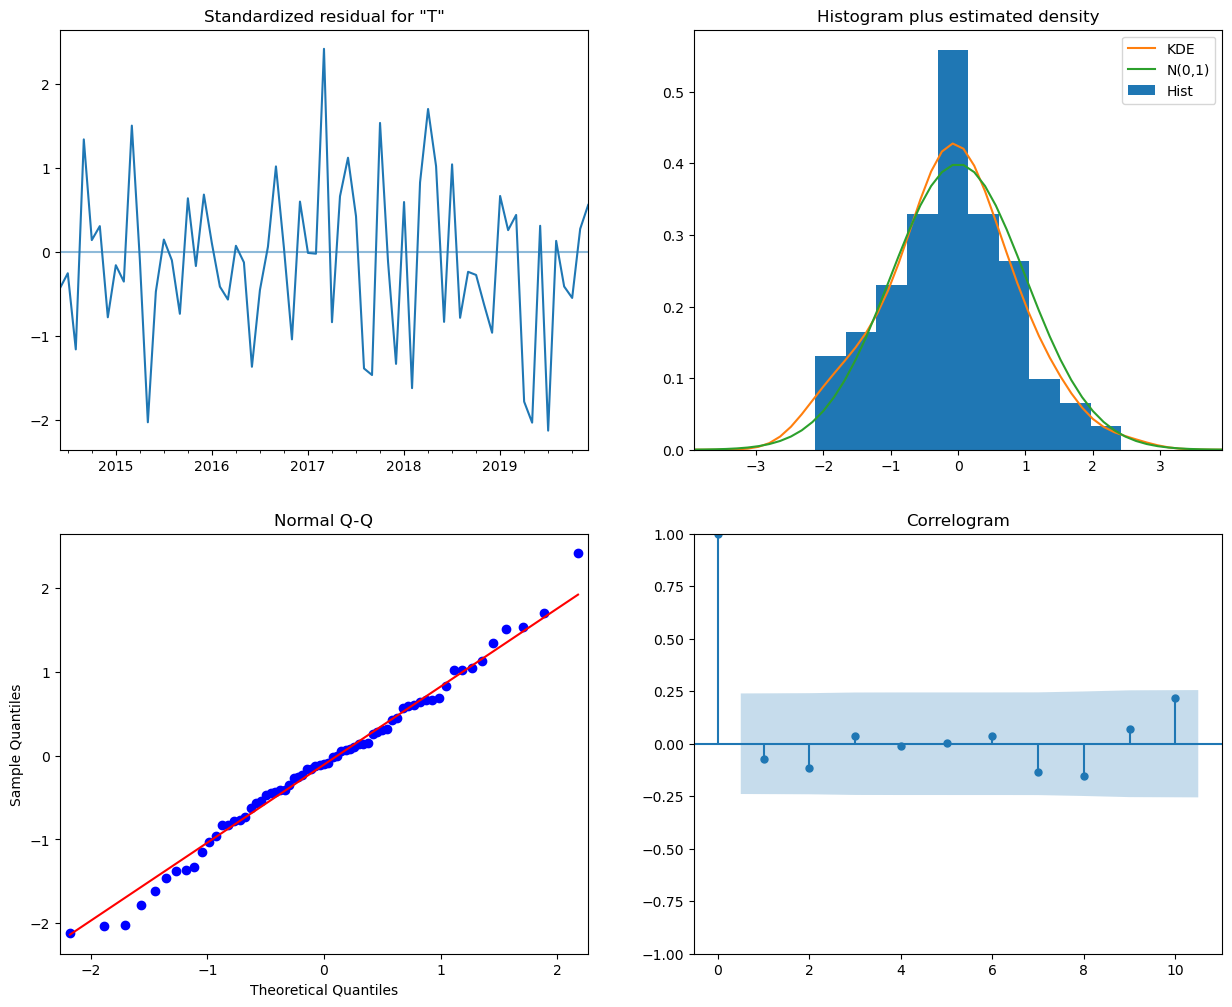

In [82]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


# Predict violence and sexual offences in April 2020

Using the SARIMAX model, it is seen from the visualization below that the time series prediction for violence and sexual offences for April 2020 is about 160,000.

In [83]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()


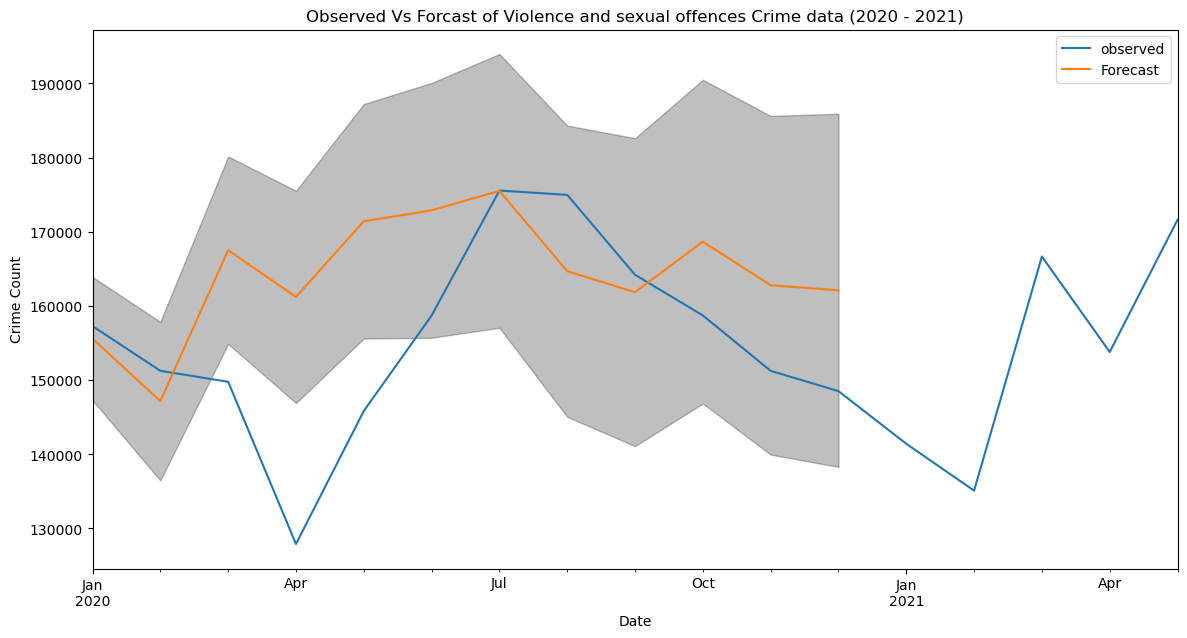

In [109]:
#To test for the prediction of April 2020, the y_to_val is used as it holds the date from 2020 and beyond.
ax = y_to_val.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
ax.set_title('Observed Vs Forcast of Violence and sexual offences Crime data (2020 - 2021)')

plt.legend()
plt.show()


# Compare predicted and observed data

Comparing the actual data and the forecasted data with the visualization below, it can be seen that the predicted data is close but not so close to the actual data. It looks like it predicted the further date just a bit too early. Moving the predicted a bit to the right, brings it very much closer to the actual data.

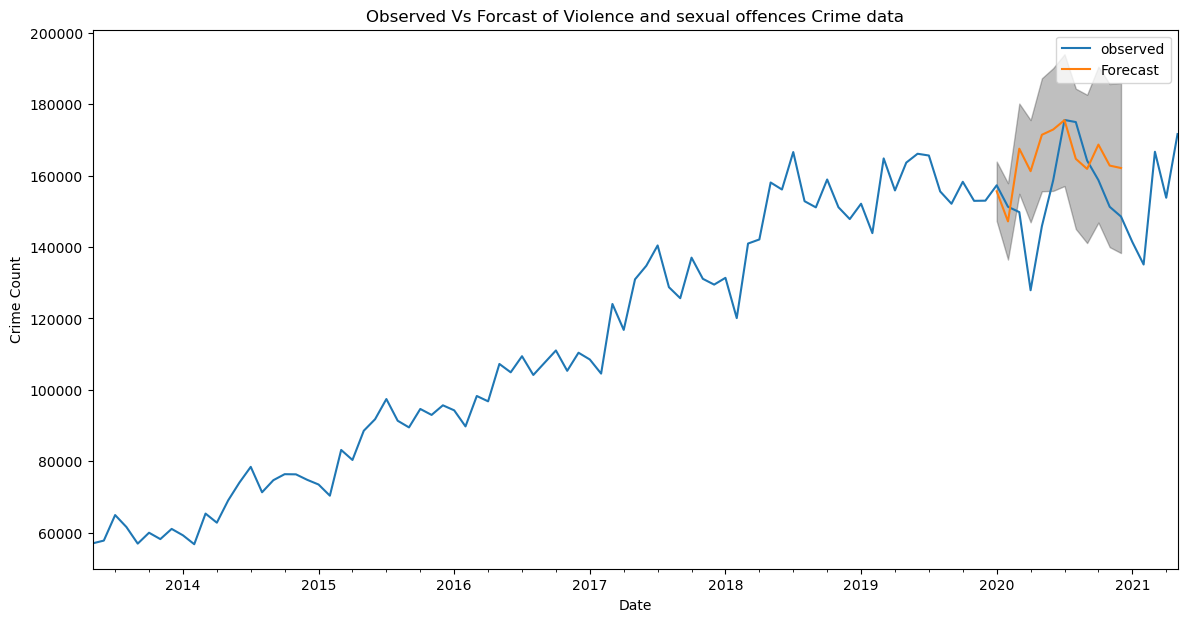

In [84]:
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
ax.set_title('Observed Vs Forcast of Violence and sexual offences Crime data')

plt.legend()
plt.show()



# Verify lockdown in July 2020

From our data analysis, it is evident that there was an increase in violence and sexual offences during the lockdown in the UK. Therefore, to verify if there was a lockdown in July 2020, the vionce and sexual offence crime in the previous months and months after July 2020 have to be observed to identify an increase in violence and sexual offences crime. 

In [102]:

dlocate = (df.select('*')
.where(df['Month']>='2020-05')
.groupBy('Crime Type', 'Month','location')
.agg(count("Crime Type").alias('Total Crime'))
.orderBy('Month')
)

dlocate2 = dlocate.where('location like "%Midlands%" or location like "%Leicester%"')

d_location_crime = dlocate2.where(dlocate2['Crime Type']=='Violence and sexual offences')

d_location_crime_pd = d_location_crime.toPandas()



Showing Crime Type that happened every month of the year from 2010 to 2021


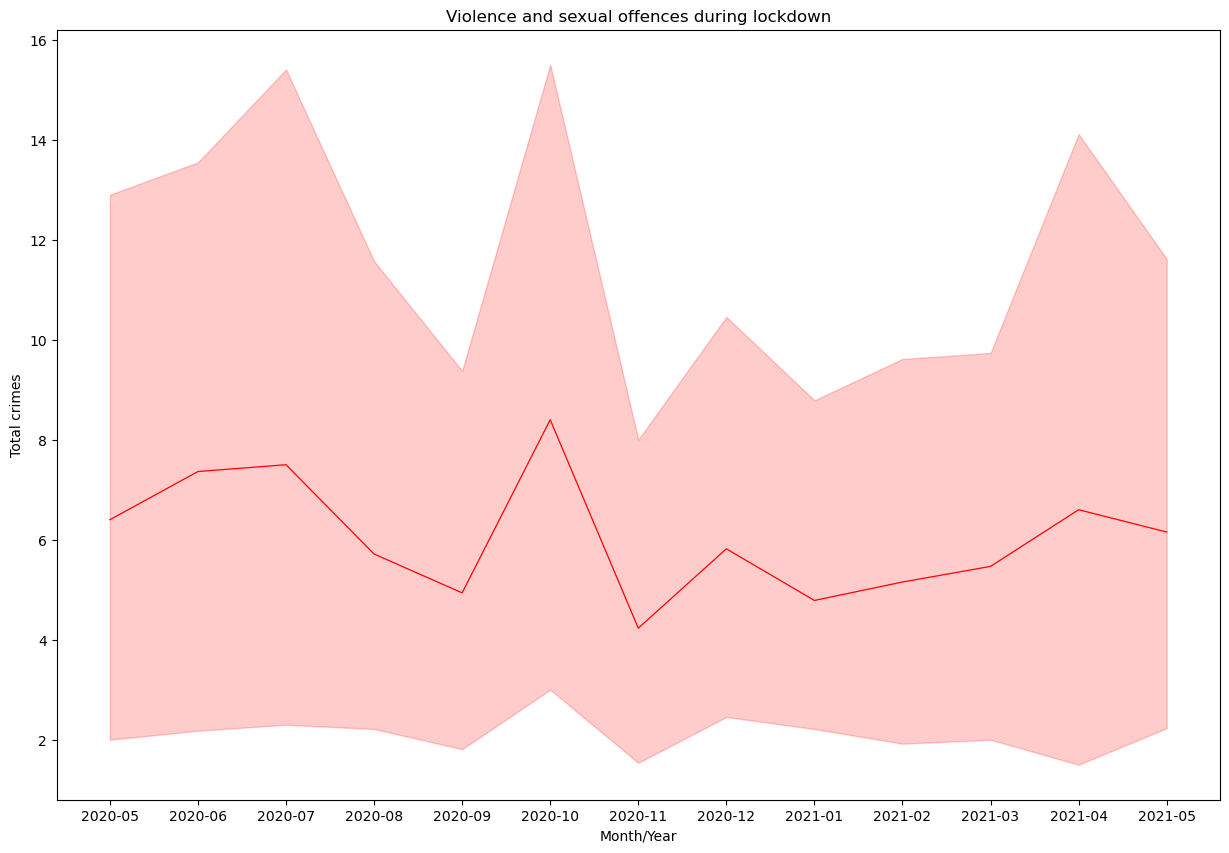

In [125]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=d_location_crime_pd, x = 'Month', y = 'Total Crime', color = 'red', linewidth=0.9)
ax.set_title("Violence and sexual offences during lockdown")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total crimes")
plt.show()

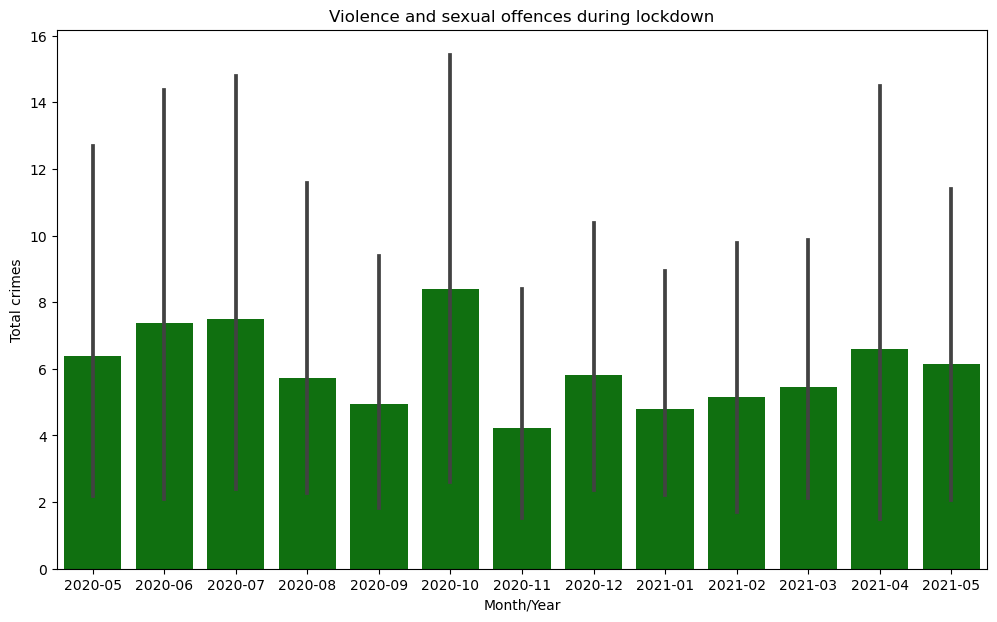

In [119]:
plt.figure(figsize=(12,7))
ax = sns.barplot(data=d_location_crime_pd, x = 'Month', y = 'Total Crime', color = 'green', linewidth=0.9)
ax.set_title("Violence and sexual offences during lockdown")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total crimes")
plt.show()

<Figure size 1200x700 with 0 Axes>

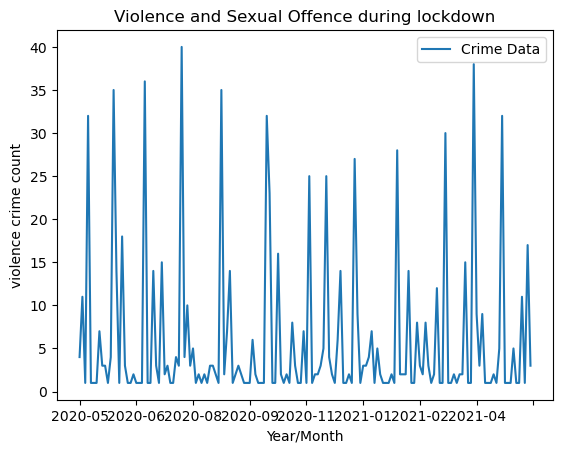

In [173]:
plt.figure(figsize=(12,7))
d_location_crime_pd.plot(y='Total Crime', x='Month',kind="line",\
subplots=False,
label='Crime Data',
title='Violence and Sexual Offence during lockdown')
plt.ylabel('violence crime count')
plt.xlabel('Year/Month')
plt.show()

From the visualization above, it is evident that there was a lockdown on July 2020, as the violence and sexual offences crime was high.